In [ ]:
!git clone https://github.com/albertakn/Neural-Optimal-Transport-in-latent-space.git
%cd Neural-Optimal-Transport-in-latent-space/
!pip install -r requirements.txt

# Prepare NOT model weights and datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp ../drive/MyDrive/YSDA/f_checkpoint_64x64.pth data/NOT_model_weights/f_checkpoint_64x64.pth
!cp ../drive/MyDrive/YSDA/T_checkpoint_64x64.pth data/NOT_model_weights/T_checkpoint_64x64.pth

!cp ../drive/MyDrive/alfa/celeba.zip data/celeba.zip
!unzip data/celeba.zip -d data/
!rm data/celeba.zip

!cp ../drive/MyDrive/YSDA/anime_datasets/archive.zip data/archive.zip
!unzip data/archive.zip -d data/
!rm data/archive.zip

## Some Hyperparameters

In [ ]:
DEVICE = 'cuda'
IMG_SIZE = 64
BATCH_SIZE = 32
ZC = 1
Z_STD = 0.1
MEAN_STD = (0.5, 0.5, 0.5)

## Prepare Samplers (X, Y)

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from src.tools.dataset import FolderDataset


class CropCelebA64:
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

celeba_dataset = torchvision.datasets.CelebA(
    root='data/celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(IMG_SIZE),
        torchvision.transforms.ToTensor(),
        transforms.Normalize(MEAN_STD, MEAN_STD),
    ]),
)


source_loader = DataLoader(celeba_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


anime_dataset = FolderDataset('data/images', 64)
target_loader = DataLoader(anime_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
iter_source, iter_target = iter(source_loader), iter(target_loader)

def X_sampler():
    global iter_source, source_loader
    try:
        return next(iter_source)[0]
    except StopIteration:
        iter_source = iter(source_loader)
        return next(iter_source)[0]

def Y_sampler():
    global iter_target, target_loader
    try:
        return next(iter_target)[0]
    except StopIteration:
        iter_target = iter(target_loader)
        return next(iter_target)[0]

# Initializing Networks

In [ ]:
import numpy as np
from src.NOT_models.resnet2 import ResNet_D
from src.NOT_models.unet import UNet

f = ResNet_D(IMG_SIZE, nc=3).to(DEVICE)
f_checkpoint = torch.load('data/NOT_model_weights/f_checkpoint_64x64.pth')
f.load_state_dict(f_checkpoint['model_state_dict'])

T = UNet(3+ZC, 3, base_factor=48).to(DEVICE)
T_checkpoint = torch.load('data/NOT_model_weights/T_checkpoint_64x64.pth')
T.load_state_dict(T_checkpoint['model_state_dict'])

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9716259
f params: 22933441


### Plots

<ipython-input-15-b885bb82db58>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


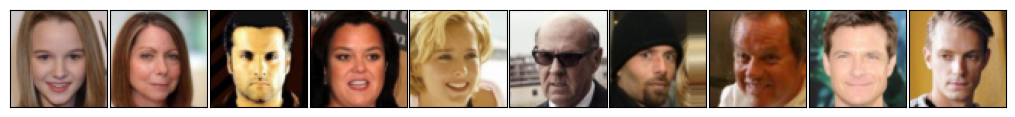

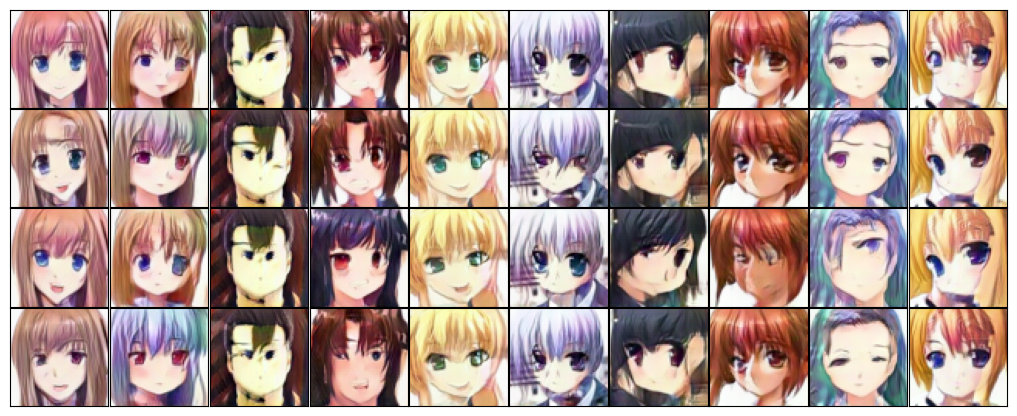

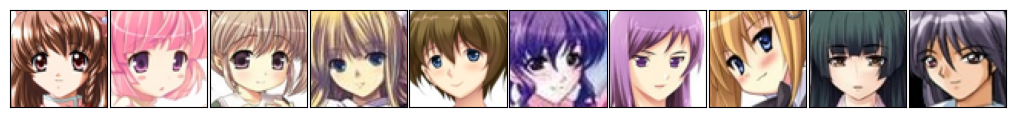

In [ ]:
from matplotlib import pyplot as plt

def plot_images(batch):
    fig, axes = plt.subplots(1, 10, figsize=(10, 1), dpi=100)
    for i in range(10):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

def plot_many_images(multibatch):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4), dpi=100)
    for i in range(10):
        for j in range(4):
            axes[j, i].imshow(multibatch[i, j].mul(0.5).add(0.5).clip(0,1).permute((1,2,0)))
            axes[j, i].set_xticks([]); axes[j, i].set_yticks([])
    fig.tight_layout(pad=0.1)


X_test_fixed = X_sampler()
with torch.no_grad():
    Z_test_fixed = torch.randn(BATCH_SIZE, 4, ZC, IMG_SIZE, IMG_SIZE, device='cpu') * Z_STD
    XZ_test_fixed = torch.cat([X_test_fixed[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)
Y_test_fixed = Y_sampler()
XZ_test_fixed.shape, Y_test_fixed.shape

plot_images(X_test_fixed)
with torch.no_grad():
    T_XZ_test_fixed = T(
        torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(3,64,64,BATCH_SIZE,4).permute(3,4,0,1,2).detach().to('cpu')
plot_many_images(T_XZ_test_fixed)
plot_images(Y_test_fixed)

In [ ]:
X_test_fixed.shape, T_XZ_test_fixed.shape, Y_test_fixed.shape

(torch.Size([32, 3, 64, 64]),
 torch.Size([32, 4, 3, 64, 64]),
 torch.Size([32, 3, 64, 64]))

# Count FID

In [ ]:
real_data = []
fake_data = []
for _ in range(100):
    X_test_fixed = X_sampler()

    with torch.no_grad():
        Z_test_fixed = torch.randn(BATCH_SIZE, 4, ZC, IMG_SIZE, IMG_SIZE, device='cpu') * Z_STD
        XZ_test_fixed = torch.cat([X_test_fixed[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)
    Y_test_fixed = Y_sampler()
    XZ_test_fixed.shape, Y_test_fixed.shape


    with torch.no_grad():
        T_XZ_test_fixed = T(
            torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(3,64,64,BATCH_SIZE,4).permute(3,4,0,1,2).detach().to('cpu')
    real_data.append(Y_test_fixed)
    fake_data.append(T_XZ_test_fixed[:, 0, :, :, :])

<ipython-input-17-7d950c011b75>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


In [ ]:
real_data = torch.concat(real_data)
real_data.shape

torch.Size([3200, 3, 64, 64])

In [ ]:
fake_data = torch.concat(fake_data)
fake_data.shape

torch.Size([3200, 3, 64, 64])

In [ ]:
from src.tools.fid import calculate_fid_score

calculate_fid_score(real_data.permute(0, 2, 3, 1), fake_data.permute(0, 2, 3, 1))

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 89.2MB/s]
100%|██████████| 100/100 [00:02<00:00, 36.65it/s]


252.53778076171875